In [2]:
import polars as pl
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler  # <-- ADD THIS LINE

# The training data path should be updated to your actual training file.
TRAIN_DATA_PATH = "./kaggle/train.csv"
SPY_DATA_PATH = "./kaggle/spy-historical.csv"



In [3]:
def generate_features_1(df: pl.DataFrame) -> pl.DataFrame:
    """Generates 40 new features from the base data.
      This function is the target of the evolutionary algorithm.
    
      Available Feature Categories:
      - D* (Dummy/Binary features): 9 columns (D1-D9)
      - E* (Macro Economic features): 20 columns (E1-E20)
      - I* (Interest Rate features): 9 columns (I1-I9)
      - M* (Market Dynamics/Technical features): 18 columns (M1-M18)
      - P* (Price/Valuation features): 13 columns (P1-P13)
      - S* (Sentiment features): 12 columns (S1-S12)
      - V* (Volatility features): 13 columns (V1-V13)
    """
    new_features = pl.DataFrame({
        # --- New Interaction Features ---
        'feat_M1_x_V10_x_P1': df['M1'] * df['V10'] * df['P1'],
        'feat_P1_add_E10_div_I5': (df['P1'] + df['E10']) / (df['I5'] + 1e-6),
        'feat_S3_div_I5_x_M12': df['S3'] / (df['I5'] + 1e-6) * df['M12'],
        'feat_M12_x_V2_x_P2': df['M12'] * df['V2'] * df['P2'],
        'feat_P2_sqrt_E4_x_S8': np.sqrt(df['P2'] * df['E4']) * df['S8'],
        'feat_M2_x_S8_x_V2': df['M2'] * df['S8'] * df['V2'],
        'feat_V10_cbrt_P5_x_E12': np.cbrt(df['V10'] * df['P5']) * df['E12'],
        'feat_E12_x_I9_x_M1': df['E12'] * df['I9'] * df['M1'],
        'feat_M1_log_V1_x_S7': np.log(df['M1'] + 1) * np.log(df['V1'] + 1) * df['S7'],
        'feat_S7_abs_P1_x_I5': np.abs(df['S7'] - df['P1']) * df['I5'],
    })
    # Fill any nulls created by rolling windows
    return new_features.with_columns(pl.all().forward_fill().backward_fill())



def generate_features_2(df: pl.DataFrame) -> pl.DataFrame:
  """Generates 10 new features from the base data.
    This function is the target of the evolutionary algorithm.
  
    Available Feature Categories:
    - D* (Dummy/Binary features): 9 columns (D1-D9)
    - E* (Macro Economic features): 20 columns (E1-E20)
    - I* (Interest Rate features): 9 columns (I1-I9)
    - M* (Market Dynamics/Technical features): 18 columns (M1-M18)
    - P* (Price/Valuation features): 13 columns (P1-P13)
    - S* (Sentiment features): 12 columns (S1-S12)
    - V* (Volatility features): 13 columns (V1-V13)
    - MOM* (Momentum features): 0 columns
  """
  cols = ['M1', 'V1', 'P1', 'E1', 'S1', 'I1', 'M10', 'V10', 'P10', 'E10']
  # Generate interaction features with exponential moving averages
  new_features = pl.DataFrame({
      #'feat_P1_add_E1': df[cols[2]] + df[cols[3]],
      #'feat_S1_sub_I1': df[cols[4]] - df[cols[5]],
      #'feat_M10_div_V10': (df[cols[6]] / (df[cols[7]] + 1e-6)),
      #'feat_P10_x_E10': df[cols[8]] * df[cols[9]],
      # Exponential moving averages instead of simple rolling means
      'feat_V1_ema_5': df[cols[1]].rolling_mean(window_size=5, min_samples=1, center=True),
      'feat_V1_ewm_std_5': df[cols[1]].rolling_std(window_size=5, min_samples=1, center=True),
      'feat_M1_ema_20': df[cols[0]].rolling_mean(window_size=20, min_samples=1, center=True),
      'feat_M1_ewm_std_20': df[cols[0]].rolling_std(window_size=20, min_samples=1, center=True),
      # Relative strength index
      'feat_RSI_14': (df[cols[2]].rolling_max(14) - df[cols[2]].rolling_min(14)) / (df[cols[2]].rolling_max(14) - df[cols[2]].rolling_min(14) + 1e-6),
  })
  return new_features.with_columns(pl.all().fill_null(0))

def generate_features_3(df: pl.DataFrame) -> pl.DataFrame:
  """Generates 10 new features from the base data.
    This function is the target of the evolutionary algorithm.
  
    Available Feature Categories:
    - D* (Dummy/Binary features): 9 columns (D1-D9)
    - E* (Macro Economic features): 20 columns (E1-E20)
    - I* (Interest Rate features): 9 columns (I1-I9)
    - M* (Market Dynamics/Technical features): 18 columns (M1-M18)
    - P* (Price/Valuation features): 13 columns (P1-P13)
    - S* (Sentiment features): 12 columns (S1-S12)
    - V* (Volatility features): 13 columns (V1-V13)
    - MOM* (Momentum features): 0 columns
  """
  cols = ['M1', 'V1', 'P1', 'E1', 'S1', 'I1', 'M10', 'V10', 'P10', 'E10']
  # Generate interaction features
  new_features = pl.DataFrame({
      # Pairwise interactions between different categories
      'feat_M1_x_V1': df[cols[0]] * df[cols[1]],
      'feat_P1_add_E1': df[cols[2]] + df[cols[3]],
      'feat_S1_sub_I1': df[cols[4]] - df[cols[5]],
      'feat_M10_div_V10': (df[cols[6]] / (df[cols[7]] + 1e-6)),
      'feat_P10_x_E10': df[cols[8]] * df[cols[9]],
      # Rolling window features on volatile columns
      'feat_V1_roll_mean_5': df[cols[1]].rolling_mean(window_size=5),
      'feat_V1_roll_std_5': df[cols[1]].rolling_std(window_size=5),
      'feat_M1_roll_mean_20': df[cols[0]].rolling_mean(window_size=20),
      'feat_M1_roll_std_20': df[cols[0]].rolling_std(window_size=20),
      # A simple ratio
      'feat_P1_div_M1': (df[cols[2]] / (df[cols[0]] + 1e-6)),
      # New feature: Exponential moving average
      'feat_M1_exp_mean_5': df[cols[0]].rolling_mean(window_size=5, min_periods=1, center=True),
  })
  # Fill any nulls created by rolling windows
  return new_features.with_columns(pl.all().forward_fill().backward_fill())

def generate_features_4(df: pl.DataFrame) -> pl.DataFrame:
  """Generates 40 new features from the base data.
    This function is the target of the evolutionary algorithm.
  
    Available Feature Categories:
    - D* (Dummy/Binary features): 9 columns (D1-D9)
    - E* (Macro Economic features): 20 columns (E1-E20)
    - I* (Interest Rate features): 9 columns (I1-I9)
    - M* (Market Dynamics/Technical features): 18 columns (M1-M18)
    - P* (Price/Valuation features): 13 columns (P1-P13)
    - S* (Sentiment features): 12 columns (S1-S12)
    - V* (Volatility features): 13 columns (V1-V13)
  """
  """Improved version of `generate_features_v0` with different features."""
  new_features = pl.DataFrame({
      # --- 20 Pairwise Interactions ---
      #'feat_M1_x_V2': df['M1'] * df['V2'],
      #'feat_P1_add_E2': df['P1'] + df['E2'],
      'feat_S1_sub_I2': df['S1'] - df['I2'],
      'feat_M10_div_V11': df['M10'] / (df['V11'] + 1e-6),
      'feat_P10_x_E11': df['P10'] * df['E11'],
      'feat_M2_x_S4': df['M2'] * df['S4'],
      'feat_V2_div_P3': df['V2'] / (df['P3'] + 1e-6),
      'feat_E4_sub_I4': df['E4'] - df['I4'],
      'feat_S7_add_M11': df['S7'] + df['M11'],
      'feat_I5_x_V12': df['I5'] * df['V12'],
      'feat_P5_div_S9': df['P5'] / (df['S9'] + 1e-6),
      'feat_E12_x_I8': df['E12'] * df['I8'],
      'feat_M1_div_S2': df['M1'] / (df['S2'] + 1e-6),
      'feat_V1_add_P2': df['V1'] + df['P2'],
      'feat_E1_sub_I2': df['E1'] - df['I2'],
      'feat_M2_div_V3': df['M2'] / (df['V3'] + 1e-6),
      'feat_P2_x_S4': df['P2'] * df['S4'],
      'feat_E4_add_M11': df['E4'] + df['M11'],
      'feat_I3_sub_V11': df['I3'] - df['V11'],
      'feat_S7_x_P11': df['S7'] * df['P11'],
      # --- 10 Rolling Window Features ---
      'feat_V2_roll_mean_5': df['V2'].rolling_mean(window_size=5),
      'feat_V2_roll_std_5': df['V2'].rolling_std(window_size=5),
      'feat_M2_roll_mean_20': df['M2'].rolling_mean(window_size=20),
      'feat_M2_roll_std_20': df['M2'].rolling_std(window_size=20),
      'feat_P2_roll_max_10': df['P2'].rolling_max(window_size=10),
      'feat_P2_roll_min_10': df['P2'].rolling_min(window_size=10),
      'feat_E2_roll_mean_50': df['E2'].rolling_mean(window_size=50),
      'feat_S2_roll_std_50': df['S2'].rolling_std(window_size=50),
      'feat_I2_roll_mean_10': df['I2'].rolling_mean(window_size=10),
      'feat_V11_roll_std_10': df['V11'].rolling_std(window_size=10),
      # --- 10 Complex Interactions (3+ elements) ---
      'feat_M1_V2_div_P2': (df['M1'] * df['V2']) / (df['P2'] + 1e-6),
      'feat_E2_S2_add_I2': df['E2'] + df['S2'] - df['I2'],
      'feat_M2_P3_sub_V3': df['M2'] + df['P3'] - df['V3'],
      'feat_S8_div_E4_I4': df['S8'] / (df['E4'] + df['I4'] + 1e-6),
      'feat_P6_x_M11_x_V11': df['P6'] * df['M11'] * df['V11'],
      'feat_roll_diff_M2_5_20': df['M2'].rolling_mean(window_size=5) - df['M2'].rolling_mean(window_size=20),
      'feat_roll_diff_V2_5_20': df['V2'].rolling_mean(window_size=5) - df['V2'].rolling_mean(window_size=20),
      'feat_M_S_P_combo_v2': (df['M11'] - df['M2']) / (df['S2'] + df['P2'] + 1e-6),
      'feat_V_E_I_combo_v2': (df['V12'] + df['V3']) * (df['E2'] - df['I2']),
      'feat_ratio_of_ratios_v2': (df['M2']/(df['V2']+1e-6)) / (df['P2']/(df['S2']+1e-6)),
  })
  # Fill any nulls created by rolling windows
  return new_features.with_columns(pl.all().forward_fill().backward_fill())

def generate_features_5(df: pl.DataFrame) -> pl.DataFrame:
    """Generates 40 new features from the base data.
      This function is the target of the evolutionary algorithm.
    
      Available Feature Categories:
      - D* (Dummy/Binary features): 9 columns (D1-D9)
      - E* (Macro Economic features): 20 columns (E1-E20)
      - I* (Interest Rate features): 9 columns (I1-I9)
      - M* (Market Dynamics/Technical features): 18 columns (M1-M18)
      - P* (Price/Valuation features): 13 columns (P1-P13)
      - S* (Sentiment features): 12 columns (S1-S12)
      - V* (Volatility features): 13 columns (V1-V13)
    """
    """Improved version of `generate_features_v2` with more complex interactions."""
    new_features = pl.DataFrame({
        'feat_M1_add_V1': df['M1'] + df['V1'],
        'feat_P1_sub_E1': df['P1'] - df['E1'],
        'feat_S1_mul_I1': df['S1'] * df['I1'],
        #'feat_M10_div_V10': df['M10'] / (df['V10'] + 1e-6),
        'feat_P10_mul_E10': df['P10'] * df['E10'],
        'feat_M2_mul_S3': df['M2'] * df['S3'],
        'feat_V2_div_P2': df['V2'] / (df['P2'] + 1e-6),
        'feat_E4_sub_I3': df['E4'] - df['I3'],
        'feat_S7_add_M12': df['S7'] + df['M12'],
        'feat_I5_mul_V11': df['I5'] * df['V11'],
        # 'feat_V1_roll_mean_5': df['V1'].rolling_mean(window_size=5),
        # 'feat_V1_roll_std_5': df['V1'].rolling_std(window_size=5),
        # 'feat_M1_roll_mean_20': df['M1'].rolling_mean(window_size=20),
        # 'feat_M1_roll_std_20': df['M1'].rolling_std(window_size=20),
        'feat_P1_roll_max_10': df['P1'].rolling_max(window_size=10),
        'feat_P1_roll_min_10': df['P1'].rolling_min(window_size=10),
        'feat_E1_roll_mean_50': df['E1'].rolling_mean(window_size=50),
        'feat_S1_roll_std_50': df['S1'].rolling_std(window_size=50),
        'feat_I1_roll_mean_10': df['I1'].rolling_mean(window_size=10),
        'feat_V10_roll_std_10': df['V10'].rolling_std(window_size=10),
        'feat_M1_V1_div_P1': (df['M1'] * df['V1']) / (df['P1'] + 1e-6),
        'feat_E1_S1_add_I1': df['E1'] + df['S1'] - df['I1'],
        'feat_M2_P2_sub_V2': df['M2'] + df['P2'] - df['V2'],
        'feat_S7_div_E4_I3': df['S7'] / (df['E4'] + df['I3'] + 1e-6),
        'feat_P5_x_M10_x_V10': df['P5'] * df['M10'] * df['V10'],
        'feat_roll_diff_M1_5_20': df['M1'].rolling_mean(window_size=5) - df['M1'].rolling_mean(window_size=20),
        'feat_roll_diff_V1_5_20': df['V1'].rolling_mean(window_size=5) - df['V1'].rolling_mean(window_size=20),
        'feat_M_S_P_combo': (df['M12'] - df['M1']) / (df['S1'] + df['P1'] + 1e-6),
        'feat_V_E_I_combo': (df['V11'] + df['V2']) * (df['E1'] - df['I1']),
        'feat_ratio_of_ratios': (df['M1']/(df['V1']+1e-6)) / (df['P1']/(df['S1']+1e-6)),
        'feat_M1_roll_skew_5': df['M1'].rolling_skew(window_size=5),
        'feat_V1_roll_kurt_5': df['V1'].rolling_kurtosis(window_size=5),
        'feat_E1_roll_skew_20': df['E1'].rolling_skew(window_size=20),
        'feat_S1_roll_kurt_20': df['S1'].rolling_kurtosis(window_size=20),
        'feat_I1_roll_skew_10': df['I1'].rolling_skew(window_size=10),
        'feat_P1_roll_kurt_10': df['P1'].rolling_kurtosis(window_size=10),
        'feat_M1_V1_E1_S1': df['M1'] * df['V1'] * df['E1'] * df['S1'],
        'feat_P1_S1_I1_V1': df['P1'] * df['S1'] * df['I1'] * df['V1'],
        'feat_M10_V10_P10_E10': df['M10'] * df['V10'] * df['P10'] * df['E10'],
        'feat_E1_S1_V1_I1': df['E1'] * df['S1'] * df['V1'] * df['I1'],
        'feat_complex_interaction': df['M1'] * (df['V1'] - df['E1']) / (df['P1'] + df['I1'] + 1e-6),
    })
    # Fill any nulls created by rolling windows
    return new_features.with_columns(pl.all().forward_fill().backward_fill())


def generate_features_6 (df: pl.DataFrame) -> pl.DataFrame:
  """Generates 40 new features from the base data.
    This function is the target of the evolutionary algorithm.
  
    Available Feature Categories:
    - D* (Dummy/Binary features): 9 columns (D1-D9)
    - E* (Macro Economic features): 20 columns (E1-E20)
    - I* (Interest Rate features): 9 columns (I1-I9)
    - M* (Market Dynamics/Technical features): 18 columns (M1-M18)
    - P* (Price/Valuation features): 13 columns (P1-P13)
    - S* (Sentiment features): 12 columns (S1-S12)
    - V* (Volatility features): 13 columns (V1-V13)
  """
  new_features = pl.DataFrame({
      # --- 10 New Pairwise Interactions ---
      'feat_M1_x_V2': df['M1'] * df['V2'],
      'feat_P1_add_E2': df['P1'] + df['E2'],
      'feat_S2_sub_I2': df['S2'] - df['I2'],
      'feat_M3_div_V3': df['M3'] / (df['V3'] + 1e-6),
      'feat_P2_x_E3': df['P2'] * df['E3'],
      'feat_M4_x_S4': df['M4'] * df['S4'],
      'feat_V4_div_P5': df['V4'] / (df['P5'] + 1e-6),
      'feat_E5_sub_I4': df['E5'] - df['I4'],
      'feat_S8_add_M13': df['S8'] + df['M13'],
      'feat_I7_x_V12': df['I7'] * df['V12'],
  })
  return new_features.with_columns(pl.all().fill_null(0))

def generate_features_7 (df: pl.DataFrame) -> pl.DataFrame:
  """Generates new features from the base data.
    This function is the target of the evolutionary algorithm.
  
    Available Feature Categories:
    - D* (Dummy/Binary features): 9 columns (D1-D9)
    - E* (Macro Economic features): 20 columns (E1-E20)
    - I* (Interest Rate features): 9 columns (I1-I9)
    - M* (Market Dynamics/Technical features): 18 columns (M1-M18)
    - P* (Price/Valuation features): 13 columns (P1-P13)
    - S* (Sentiment features): 12 columns (S1-S12)
    - V* (Volatility features): 13 columns (V1-V13)
  """
  new_features = pl.DataFrame({
      # --- 20 Pairwise Interactions ---
      'feat_M1_x_V1': df['M1'] * df['V1'],
      'feat_P1_add_E1': df['P1'] + df['E1'],
      'feat_S1_sub_I1': df['S1'] - df['I1'],
      'feat_M10_div_V10': df['M10'] / (df['V10'] + 1e-6),
      'feat_P10_x_E10': df['P10'] * df['E10'],
      'feat_M2_x_S3': df['M2'] * df['S3'],
      'feat_V2_div_P2': df['V2'] / (df['P2'] + 1e-6),
      'feat_E4_sub_I3': df['E4'] - df['I3'],
      'feat_S7_add_M12': df['S7'] + df['M12'],
      'feat_I5_x_V11': df['I5'] * df['V11'],
      'feat_P5_div_S8': df['P5'] / (df['S8'] + 1e-6),
      'feat_E12_x_I9': df['E12'] * df['I9'],
      'feat_M1_div_S1': df['M1'] / (df['S1'] + 1e-6),
      'feat_V1_add_P1': df['V1'] + df['P1'],
      'feat_E1_sub_I1': df['E1'] - df['I1'],
      'feat_M2_div_V2': df['M2'] / (df['V2'] + 1e-6),
      'feat_P2_x_S3': df['P2'] * df['S3'],
      'feat_E4_add_M10': df['E4'] + df['M10'],
      'feat_I3_sub_V10': df['I3'] - df['V10'],
      'feat_S7_x_P10': df['S7'] * df['P10'],
      # --- 10 Rolling Window Features ---
      'feat_V2_roll_mean_5': df['V2'].rolling_mean(window_size=5),
      'feat_V1_roll_std_5': df['V1'].rolling_std(window_size=5),
      'feat_M1_roll_mean_20': df['M1'].rolling_mean(window_size=20),
      'feat_M3_roll_std_20': df['M3'].rolling_std(window_size=20),
      'feat_P1_roll_max_10': df['P1'].rolling_max(window_size=10),
      'feat_P1_roll_min_10': df['P1'].rolling_min(window_size=10),
      'feat_E5_roll_mean_50': df['E5'].rolling_mean(window_size=50),
      'feat_S1_roll_std_50': df['S1'].rolling_std(window_size=50),
      'feat_I1_roll_mean_10': df['I1'].rolling_mean(window_size=10),
      'feat_V10_roll_std_10': df['V10'].rolling_std(window_size=10),
      # --- 10 Complex Interactions (3+ elements) ---
      'feat_M1_V1_div_P1': (df['M1'] * df['V1']) / (df['P1'] + 1e-6),
      'feat_E1_S1_add_I1': df['E1'] + df['S1'] - df['I1'],
      'feat_M2_P2_sub_V2': df['M2'] + df['P2'] - df['V2'],
      'feat_S7_div_E4_I3': df['S7'] / (df['E4'] + df['I3'] + 1e-6),
      'feat_P5_x_M10_x_V10': df['P5'] * df['M10'] * df['V10'],
      'feat_roll_diff_M1_5_20': df['M1'].rolling_mean(window_size=5) - df['M1'].rolling_mean(window_size=20),
      'feat_roll_diff_V1_5_20': df['V1'].rolling_mean(window_size=5) - df['V1'].rolling_mean(window_size=20),
      'feat_M_S_P_combo': (df['M12'] - df['M1']) / (df['S1'] + df['P1'] + 1e-6),
      'feat_V_E_I_combo': (df['V11'] + df['V2']) * (df['E1'] - df['I1']),
      'feat_ratio_of_ratios': (df['M1']/(df['V1']+1e-6)) / (df['P1']/(df['S1']+1e-6)),
      # --- 10 New Features ---
      'feat_M1_x_V1_x_P1': df['M1'] * df['V1'] * df['P1'],
      'feat_E1_div_S1': df['E1'] / (df['S1'] + 1e-6),
      'feat_I1_sub_V1': df['I1'] - df['V1'],
      'feat_M10_add_V10': df['M10'] + df['V10'],
      'feat_P10_div_E10': df['P10'] / (df['E10'] + 1e-6),
      'feat_M2_add_S3': df['M2'] + df['S3'],
      'feat_V2_x_P2': df['V2'] * df['P2'],
      'feat_E4_add_I3': df['E4'] + df['I3'],
      'feat_S7_div_M12': df['S7'] / (df['M12'] + 1e-6),
      'feat_I5_div_V11': df['I5'] / (df['V11'] + 1e-6),
      'feat_M1_log_P1': np.log(df['M1'] + 1e-6) / np.log(df['P1'] + 1e-6),
  })
  # Fill any nulls created by rolling windows
  return new_features.with_columns(pl.all().forward_fill())
  return new_features.with_columns(pl.all().forward_fill().backward_fill())




In [ ]:

def evaluate(excessarg: int) -> float:
    """
    Main evaluation function for FunSearch. It loads the data
    and runs the solver which performs cross-validation.
    """
    full_train_df = pl.read_csv(TRAIN_DATA_PATH)
    # Use a slice of data for faster evaluation runs during development
    df_raw = full_train_df.slice(4000)
    print(df_raw.shape)

    #fill nulls in df with mean
    df = df_raw.with_columns(
        # Select all numeric columns for the operation
        pl.selectors.numeric()
          # Step 1: Attempt to fill with the rolling mean of each respective column
          .fill_null(
              pl.selectors.numeric().rolling_mean(window_size=5, min_samples=1)
          )
          # Step 2: Fall back to the global column mean for any remaining nulls
          #.fill_null(strategy='mean')
    )
    df = df.with_columns(
    pl.col("date_id").cast(pl.Int64)
    )
    
    weekday_df = add_weekday_column(SPY_DATA_PATH)
    print("\n--- Joining weekday feature onto sliced data ---")
    # Join the weekday information onto the sliced training data.
    # A 'left' join ensures we keep all rows from the original `df`.
    df_with_features = df.join(weekday_df, on="date_id", how="left")
    # print("DataFrame after join:")
    # print(df_with_features.shape)
    return solve(df_with_features)
  
def add_weekday_column(input_csv_path: str) -> pl.DataFrame:
    """
    Reads a CSV file, adds a 'weekday' column based on the 'Date' column,
    and saves the result to a new CSV file.

    Args:
        input_csv_path (str): The path to the source CSV file.
        output_csv_path (str): The path where the output CSV will be saved.
    """
    # Read the CSV file into a Polars DataFrame
    df = pl.read_csv(input_csv_path)

    # Add a new column named 'weekday'
    # 1. Select the 'Date' column.
    # 2. Convert the string representation to a proper date type.
    # 3. Use the .dt.weekday() function to get the day of the week (Monday=1, Sunday=7).
    # 4. Alias the new expression to 'weekday'.
    df_with_weekday = df.with_columns(
        pl.col("Date").str.to_date().dt.weekday().alias("weekday")
    )

    # Print the transformed DataFrame to the console to show the result
    returned_df = df_with_weekday.select(["date_id", "weekday"])
    return returned_df

# def solve(df: pl.DataFrame) -> float:
#     """
#     A placeholder for the user's actual solving/modeling function.
#     This dummy function just prints the DataFrame it receives to show
#     that the join operation was successful.
#     """
#     print("--- DataFrame passed to solve() ---")
#     print(df.shape)
#     # In a real scenario, this would return a score based on a model's performance
#     # If the dataframe passed here is empty, a CV function would fail.
#     if df.height == 0:
#         raise ValueError("DataFrame passed to solve() is empty.")
#     return 1.0

def solve(df: pl.DataFrame) -> float:
    """
    Runs a full time-series cross-validation process to evaluate
    the features generated by the `generate_features` function.
    This version pre-generates features to avoid a CPU bottleneck.
    """
    # --- Helper functions (unchanged) ---
    def calculate_competition_score(y_true_df: pl.DataFrame, y_pred_signals: np.ndarray) -> float:
        ''' Calculates the competition score based on true values and predicted signals. '''
        solution = y_true_df.to_pandas()
        solution['position'] = y_pred_signals
        solution['strategy_returns'] = (
            solution['risk_free_rate'] * (1 - solution['position']) +
            solution['position'] * solution['forward_returns']
        )
        strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
        strategy_geo_mean = (1 + strategy_excess_returns).prod() ** (1 / len(solution)) - 1
        strategy_std = solution['strategy_returns'].std()
        if strategy_std == 0: return 0.0
        trading_days_per_yr = 252
        sharpe = strategy_geo_mean / strategy_std * np.sqrt(trading_days_per_yr)
        market_std = solution['forward_returns'].std()
        market_volatility = market_std * np.sqrt(trading_days_per_yr) * 100
        strategy_volatility = strategy_std * np.sqrt(trading_days_per_yr) * 100
        excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
        vol_penalty = 1 + excess_vol
        market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
        market_geo_mean = (1 + market_excess_returns).prod() ** (1 / len(solution)) - 1
        return_gap = max(0, (market_geo_mean - strategy_geo_mean) * 100 * trading_days_per_yr)
        return_penalty = 1 + (return_gap**2) / 100
        adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
        print(f"Strategy Volatility: {strategy_volatility:.2f}%, Market Volatility: {market_volatility:.2f}%, Sharpe: {sharpe:.4f}, Adjusted Sharpe: {adjusted_sharpe:.4f}")
        return adjusted_sharpe

    def convert_to_signal(predictions: np.ndarray, multiplier: float = 300.0) -> np.ndarray:
        ''' Converts raw model predictions into trading signals in the range [0, 2]. '''
        signals = predictions * multiplier + 0.8
        return np.clip(signals, 0.0, 2.0)

    # --- Feature Generation and Data Prep (Moved Outside the Loop) ---
    #print("Preparing data and generating features once...")
    print(f"Initial DataFrame shape: {df.shape}")
    # 1. Prepare base data
    base_df = df.rename({'market_forward_excess_returns': 'target'})
    feature_cols = [col for col in base_df.columns if col != 'date_id']
    print(f"Base DataFrame shape before cleaning: {base_df.shape}")
    base_df = base_df.with_columns(pl.col(feature_cols).cast(pl.Float64, strict=False))
    #base_df.write_csv("debug_base_df_before_cleaning.csv")
    base_df = base_df.drop('E7')
    print(f"Base DataFrame shape during cleaning: {base_df.shape}")
    
    df = df.with_columns(
    pl.col("date_id").cast(pl.Int64)
    )
    base_df = base_df.with_columns(pl.all().forward_fill())
    #base_df = base_df.with_columns(pl.all().forward_fill()).drop_nulls()
    print(f"Base DataFrame shape after cleaning: {base_df.shape}")


    # 2. Generate new features using the evolved function
    new_features_df_1 = generate_features_1(base_df)
    new_features_df_2 = generate_features_2(base_df)
    new_features_df_3 = generate_features_3(base_df)
    new_features_df_4 = generate_features_4(base_df)
    new_features_df_5 = generate_features_5(base_df)
    new_features_df_6 = generate_features_6(base_df)
    new_features_df_7 = generate_features_7(base_df)
    newf = [new_features_df_1, new_features_df_2, new_features_df_3, new_features_df_4,new_features_df_5, new_features_df_6]
    newf = [new_features_df_1, new_features_df_2, new_features_df_6]
    newf = [new_features_df_1, new_features_df_5]
    new_features_df = pl.concat(newf, how="horizontal")
    new_features_df = generate_features_7(base_df)

    # 3. Combine base data with new features
    processed_df = pl.concat([base_df, new_features_df], how="horizontal")
    #processed_df = base_df

    print(f"Processed DataFrame shape: {processed_df.shape}")

    # 4. Set up data for modeling
    base_features = [col for col in base_df.columns if col not in ["date_id", "forward_returns", "risk_free_rate", "target"]]
    new_feature_names = new_features_df.columns
    ALL_FEATURES = base_features + new_feature_names
    #ALL_FEATURES = ['']
    TARGET_COL = "target"

    X = processed_df.select(ALL_FEATURES)
    y = processed_df.select(TARGET_COL)
    scorer_info_df = processed_df.select(["forward_returns", "risk_free_rate"])

    # --- Time-Series Cross-Validation (Loop is now much lighter) ---
    # print("Starting cross-validation loop...")
    nsplits = 20
    tscv = TimeSeriesSplit(n_splits=nsplits)
    cv_scores = []
    entire_signal = []
    entire_ytest = scorer_info_df.clear()

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        #print(f"  Starting Fold {i+1}/{nsplits}...")
        # X_train, X_test = X[train_index], X[test_index]
        # y_train = y[train_index]
        # y_test_info = scorer_info_df[test_index]

        # 1. Get the raw Polars dataframes for this split
        X_train_raw = X[train_index]
        X_test_raw = X[test_index]
        y_train = y[train_index]
        y_test_info = scorer_info_df[test_index]

        # --- START: Normalization Code ---
        # 2. Initialize the scaler
        scaler = StandardScaler()

        # 3. Fit the scaler ONLY on the training data (converted to NumPy)
        #    and transform the training data
        X_train = scaler.fit_transform(X_train_raw.to_numpy())

        # 4. Transform the test data using the SAME scaler
        X_test = scaler.transform(X_test_raw.to_numpy())
        # --- END: Normalization Code ---

        model = xgb.XGBRegressor(
            objective='reg:absoluteerror', n_estimators=50, device='cuda',
            learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8,
            n_jobs=-1, random_state=42
        )
        
        # GPU is now the primary worker here
        model.fit(X_train, y_train, verbose=False)

        predictions = model.predict(X_test)
        signals = convert_to_signal(predictions)
        score = calculate_competition_score(y_test_info, signals)
        cv_scores.append(score)
        entire_signal.extend(signals)
        entire_ytest.extend(y_test_info)
        #print(f"  Fold {i+1}/{nsplits} Score: {score:.4f}")

    mean_score = np.mean(cv_scores)
    print(f"\nMean CV Score: {mean_score:.4f}, std: {np.std(cv_scores):.4f}")
    overall_score = calculate_competition_score(entire_ytest, entire_signal)
    print(f" Overall Score Calculation: {overall_score:.4f}")
    return overall_score

if __name__ == "__main__":
    # Example call to evaluate function
    final_score = evaluate(0)
    print(f"Final Evaluation Score: {final_score:.4f}")

(4990, 98)

--- Joining weekday feature onto sliced data ---
Initial DataFrame shape: (4990, 99)
Base DataFrame shape before cleaning: (4990, 99)
Base DataFrame shape during cleaning: (4990, 98)
Base DataFrame shape after cleaning: (4990, 98)
Processed DataFrame shape: (4990, 149)
Strategy Volatility: 11.38%, Market Volatility: 13.21%, Sharpe: 0.7761, Adjusted Sharpe: 0.7761


/tmp/ipykernel_11666/185523524.py:17: DeprecationWarning: the argument `min_periods` for `Expr.rolling_mean` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.selectors.numeric().rolling_mean(window_size=5, min_periods=1)
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/polars/series/series.py:1571: RuntimeWarning: invalid value encountered in log
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_var

Strategy Volatility: 22.79%, Market Volatility: 21.92%, Sharpe: 0.0960, Adjusted Sharpe: 0.0960
Strategy Volatility: 49.34%, Market Volatility: 33.66%, Sharpe: -0.5628, Adjusted Sharpe: -0.0885


/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/en

Strategy Volatility: 19.77%, Market Volatility: 18.61%, Sharpe: 0.5394, Adjusted Sharpe: 0.5394
Strategy Volatility: 10.91%, Market Volatility: 13.14%, Sharpe: 1.2802, Adjusted Sharpe: 0.6026


/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/en

Strategy Volatility: 29.72%, Market Volatility: 22.43%, Sharpe: 0.2100, Adjusted Sharpe: 0.1818
Strategy Volatility: 7.82%, Market Volatility: 11.85%, Sharpe: 1.7270, Adjusted Sharpe: 1.0671


/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/en

Strategy Volatility: 9.68%, Market Volatility: 10.99%, Sharpe: 2.0634, Adjusted Sharpe: 2.0634
Strategy Volatility: 15.90%, Market Volatility: 11.69%, Sharpe: 1.0296, Adjusted Sharpe: 0.8870
Strategy Volatility: 20.15%, Market Volatility: 16.89%, Sharpe: 0.5209, Adjusted Sharpe: 0.5209
Strategy Volatility: 11.07%, Market Volatility: 9.95%, Sharpe: 1.3846, Adjusted Sharpe: 1.3142
Strategy Volatility: 8.24%, Market Volatility: 10.09%, Sharpe: 1.6707, Adjusted Sharpe: 1.5496
Strategy Volatility: 22.49%, Market Volatility: 16.21%, Sharpe: 0.1740, Adjusted Sharpe: 0.1466
Strategy Volatility: 12.57%, Market Volatility: 11.79%, Sharpe: 1.5189, Adjusted Sharpe: 1.5134
Strategy Volatility: 44.33%, Market Volatility: 26.01%, Sharpe: 0.8171, Adjusted Sharpe: 0.5431
Strategy Volatility: 12.97%, Market Volatility: 12.50%, Sharpe: 1.9830, Adjusted Sharpe: 1.9830
Strategy Volatility: 37.14%, Market Volatility: 23.74%, Sharpe: -0.4369, Adjusted Sharpe: -0.3201
Strategy Volatility: 14.31%, Market Volat

/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/polars/series/series.py:1571: RuntimeWarning: invalid value encountered in log
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),



Running with n_estimators=1...
 -> Score: 0.5878

Running with n_estimators=2...
 -> Score: 0.5996

Running with n_estimators=3...
 -> Score: 0.5820

Running with n_estimators=4...
 -> Score: 0.5576

Running with n_estimators=5...
 -> Score: 0.5254

Running with n_estimators=6...
 -> Score: 0.5308

Running with n_estimators=7...
 -> Score: 0.5422

Running with n_estimators=8...
 -> Score: 0.5309

Running with n_estimators=9...
 -> Score: 0.5380

Running with n_estimators=10...
 -> Score: 0.5257

Running with n_estimators=11...
 -> Score: 0.5358

Running with n_estimators=12...
 -> Score: 0.5518

Running with n_estimators=13...
 -> Score: 0.5699

Running with n_estimators=14...
 -> Score: 0.5838

Running with n_estimators=15...
 -> Score: 0.5985

Running with n_estimators=16...
 -> Score: 0.6054

Running with n_estimators=17...
 -> Score: 0.5996

Running with n_estimators=18...
 -> Score: 0.5957

Running with n_estimators=19...
 -> Score: 0.5953

Running with n_estimators=20...
 -> Sco

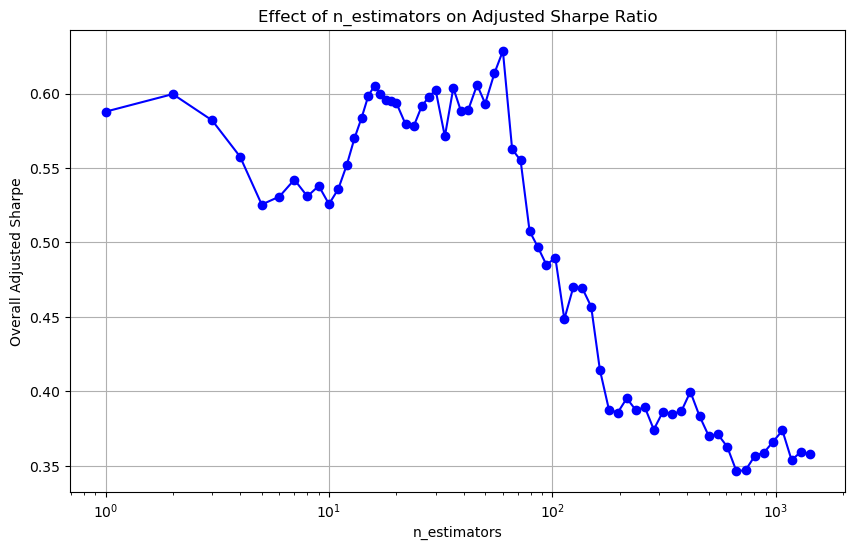

In [9]:
import polars as pl
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# --- Helper Functions (Competition Score & Signal Conversion) ---
def calculate_competition_score(y_true_df: pl.DataFrame, y_pred_signals: np.ndarray) -> float:
    solution = y_true_df.to_pandas()
    solution['position'] = y_pred_signals
    # Calculate strategy returns
    solution['strategy_returns'] = (
        solution['risk_free_rate'] * (1 - solution['position']) +
        solution['position'] * solution['forward_returns']
    )
    # Metrics
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
    strategy_geo_mean = (1 + strategy_excess_returns).prod() ** (1 / len(solution)) - 1
    strategy_std = solution['strategy_returns'].std()
    
    if strategy_std == 0: return 0.0
    
    trading_days_per_yr = 252
    sharpe = strategy_geo_mean / strategy_std * np.sqrt(trading_days_per_yr)
    
    market_std = solution['forward_returns'].std()
    market_volatility = market_std * np.sqrt(trading_days_per_yr) * 100
    strategy_volatility = strategy_std * np.sqrt(trading_days_per_yr) * 100
    
    # Penalties
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol
    
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
    market_geo_mean = (1 + market_excess_returns).prod() ** (1 / len(solution)) - 1
    return_gap = max(0, (market_geo_mean - strategy_geo_mean) * 100 * trading_days_per_yr)
    return_penalty = 1 + (return_gap**2) / 100
    
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return adjusted_sharpe

def convert_to_signal(predictions: np.ndarray, multiplier: float = 300.0) -> np.ndarray:
    # Standard signal logic from Block 1
    signals = predictions * multiplier + 0.8
    return np.clip(signals, 0.0, 2.0)

def run_hyperparameter_search():
    # 1. Load and Preprocess Data (Assuming this part works as in your notebook)
    full_train_df = pl.read_csv(TRAIN_DATA_PATH)
    df_raw = full_train_df.slice(3000)
    
    # Fill nulls
    df = df_raw.with_columns(
        pl.selectors.numeric().fill_null(
            pl.selectors.numeric().rolling_mean(window_size=5, min_samples=1)
        )
    )
    df = df.with_columns(pl.col("date_id").cast(pl.Int64))
    
    # Join features (Make sure add_weekday_column is defined or imported)
    # weekday_df = add_weekday_column(SPY_DATA_PATH)
    # df = df.join(weekday_df, on="date_id", how="left")
    
    # 2. Generate Features (Assuming generate_features_7 is defined)
    base_df = df.rename({'market_forward_excess_returns': 'target'})
    feature_cols = [col for col in base_df.columns if col != 'date_id']
    base_df = base_df.with_columns(pl.col(feature_cols).cast(pl.Float64, strict=False))
    base_df = base_df.drop('E7').with_columns(pl.all().forward_fill())
    
    new_features_df = generate_features_7(base_df)
    processed_df = pl.concat([base_df, new_features_df], how="horizontal")
    
    # 3. Setup X and y
    base_features = [col for col in base_df.columns if col not in ["date_id", "forward_returns", "risk_free_rate", "target"]]
    ALL_FEATURES = base_features + new_features_df.columns
    TARGET_COL = "target"
    
    X_all = processed_df.select(ALL_FEATURES)
    y_all = processed_df.select(TARGET_COL)
    scorer_info_all = processed_df.select(["forward_returns", "risk_free_rate"])
    
    # --- HYPERPARAMETER SEARCH LOOP ---
    n_estimators_list = []
    sharpe_scores = []
    
    current_n = 1
    while current_n <= 1500:
        print(f"\nRunning with n_estimators={current_n}...")
        
        tscv = TimeSeriesSplit(n_splits=10)
        entire_signal = []
        entire_ytest = scorer_info_all.clear()
        
        # CV Loop
        for i, (train_index, test_index) in enumerate(tscv.split(X_all)):
            X_train = X_all[train_index].to_numpy() # No scaler
            X_test  = X_all[test_index].to_numpy()  # No scaler
            y_train = y_all[train_index].to_numpy()
            y_test_info = scorer_info_all[test_index]
            
            # Model Training
            model = xgb.XGBRegressor(
                objective='reg:absoluteerror', 
                n_estimators=current_n,  # Variable n_estimators
                device='cuda', # Use 'cpu' if no GPU available
                learning_rate=0.05, 
                max_depth=5, 
                subsample=0.8, 
                colsample_bytree=0.8,
                n_jobs=-1, 
                random_state=42
            )
            
            model.fit(X_train, y_train, verbose=False)
            
            predictions = model.predict(X_test)
            signals = convert_to_signal(predictions)
            
            entire_signal.extend(signals)
            entire_ytest.extend(y_test_info)
        
        # Calculate Overall Adjusted Sharpe
        overall_score = calculate_competition_score(entire_ytest, entire_signal)
        print(f" -> Score: {overall_score:.4f}")
        
        n_estimators_list.append(current_n)
        sharpe_scores.append(overall_score)
        
        # Increment by 10% (ensure at least +1 increase)
        next_n = int(current_n * 1.10)
        current_n = next_n if next_n > current_n else current_n + 1

    # --- PLOTTING ---
    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_list, sharpe_scores, marker='o', linestyle='-', color='b')
    plt.title('Effect of n_estimators on Adjusted Sharpe Ratio')
    plt.xlabel('n_estimators')
    plt.ylabel('Overall Adjusted Sharpe')
    plt.xscale('log') # Log scale enabled
    plt.grid(True)
    plt.show()

# Run the search

run_hyperparameter_search()

In [ ]:
def evaluate(excessarg: int) -> float:
    """
    Main evaluation function for FunSearch. It loads the data
    and runs the solver which performs cross-validation.
    """
    full_train_df = pl.read_csv(TRAIN_DATA_PATH)
    # Use a slice of data for faster evaluation runs during development
    df_raw = full_train_df.slice(4000)
    print(df_raw.shape)

    #fill nulls in df with mean
    df = df_raw.with_columns(
        # Select all numeric columns for the operation
        pl.selectors.numeric()
          # Step 1: Attempt to fill with the rolling mean of each respective column
          .fill_null(
              pl.selectors.numeric().rolling_mean(window_size=5, min_samples=1)
          )
          # Step 2: Fall back to the global column mean for any remaining nulls
          #.fill_null(strategy='mean')
    )
    df = df.with_columns(
    pl.col("date_id").cast(pl.Int64)
    )
    
    weekday_df = add_weekday_column(SPY_DATA_PATH)
    print("\n--- Joining weekday feature onto sliced data ---")
    # Join the weekday information onto the sliced training data.
    # A 'left' join ensures we keep all rows from the original `df`.
    df_with_features = df.join(weekday_df, on="date_id", how="left")
    # print("DataFrame after join:")
    # print(df_with_features.shape)
    return solve(df_with_features)
  
def add_weekday_column(input_csv_path: str) -> pl.DataFrame:
    """
    Reads a CSV file, adds a 'weekday' column based on the 'Date' column,
    and saves the result to a new CSV file.

    Args:
        input_csv_path (str): The path to the source CSV file.
        output_csv_path (str): The path where the output CSV will be saved.
    """
    # Read the CSV file into a Polars DataFrame
    df = pl.read_csv(input_csv_path)

    # Add a new column named 'weekday'
    # 1. Select the 'Date' column.
    # 2. Convert the string representation to a proper date type.
    # 3. Use the .dt.weekday() function to get the day of the week (Monday=1, Sunday=7).
    # 4. Alias the new expression to 'weekday'.
    df_with_weekday = df.with_columns(
        pl.col("Date").str.to_date().dt.weekday().alias("weekday")
    )

    # Print the transformed DataFrame to the console to show the result
    returned_df = df_with_weekday.select(["date_id", "weekday"])
    return returned_df


def solve(df: pl.DataFrame) -> float:
    """
    Predicts pre computed optimal postions, rather than forward return
    """
    # --- Helper functions (unchanged) ---
    def calculate_competition_score(y_true_df: pl.DataFrame, y_pred_signals: np.ndarray) -> float:
        ''' Calculates the competition score based on true values and predicted signals. '''
        solution = y_true_df.to_pandas()
        solution['position'] = y_pred_signals
        solution['position'] = solution['position'].clip(0, 2)
        solution['strategy_returns'] = (
            solution['risk_free_rate'] * (1 - solution['position']) +
            solution['position'] * solution['forward_returns']
        )
        strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
        strategy_geo_mean = (1 + strategy_excess_returns).prod() ** (1 / len(solution)) - 1
        strategy_std = solution['strategy_returns'].std()
        if strategy_std == 0: return 0.0
        trading_days_per_yr = 252
        sharpe = strategy_geo_mean / strategy_std * np.sqrt(trading_days_per_yr)
        market_std = solution['forward_returns'].std()
        market_volatility = market_std * np.sqrt(trading_days_per_yr) * 100
        strategy_volatility = strategy_std * np.sqrt(trading_days_per_yr) * 100
        excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
        vol_penalty = 1 + excess_vol
        market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
        market_geo_mean = (1 + market_excess_returns).prod() ** (1 / len(solution)) - 1
        return_gap = max(0, (market_geo_mean - strategy_geo_mean) * 100 * trading_days_per_yr)
        return_penalty = 1 + (return_gap**2) / 100
        adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
        print(f"Strategy Volatility: {strategy_volatility:.2f}%, Market Volatility: {market_volatility:.2f}%, Sharpe: {sharpe:.4f}, Adjusted Sharpe: {adjusted_sharpe:.4f}")
        return adjusted_sharpe

    def convert_to_signal(predictions: np.ndarray, multiplier: float = 300.0) -> np.ndarray:
        ''' Converts raw model predictions into trading signals in the range [0, 2]. '''
        return np.clip(predictions, 0.0, 2.0)

    # --- Feature Generation and Data Prep (Moved Outside the Loop) ---
    #print("Preparing data and generating features once...")
    print(f"Initial DataFrame shape: {df.shape}")
    # 1. Prepare base data
    base_df = df.rename({'market_forward_excess_returns': 'target'})
    feature_cols = [col for col in base_df.columns if col != 'date_id']
    print(f"Base DataFrame shape before cleaning: {base_df.shape}")
    base_df = base_df.with_columns(pl.col(feature_cols).cast(pl.Float64, strict=False))
    #base_df.write_csv("debug_base_df_before_cleaning.csv")
    base_df = base_df.drop('E7')
    print(f"Base DataFrame shape during cleaning: {base_df.shape}")
    
    df = df.with_columns(
    pl.col("date_id").cast(pl.Int64)
    )
    base_df = base_df.with_columns(pl.all().forward_fill())
    #base_df = base_df.with_columns(pl.all().forward_fill()).drop_nulls()
    print(f"Base DataFrame shape after cleaning: {base_df.shape}")


    # 2. Generate new features using the evolved function
    # new_features_df_1 = generate_features_1(base_df)
    # new_features_df_2 = generate_features_2(base_df)
    # new_features_df_3 = generate_features_3(base_df)
    # new_features_df_4 = generate_features_4(base_df)
    # new_features_df_5 = generate_features_5(base_df)
    # new_features_df_6 = generate_features_6(base_df)
    # new_features_df_7 = generate_features_7(base_df)
    # newf = [new_features_df_1, new_features_df_2, new_features_df_3, new_features_df_4,new_features_df_5, new_features_df_6]
    # newf = [new_features_df_1, new_features_df_2, new_features_df_6]
    # newf = [new_features_df_1, new_features_df_5]
    # new_features_df = pl.concat(newf, how="horizontal")
    new_features_df = generate_features_7(base_df)

    # 3. Combine base data with new features
    processed_df = pl.concat([base_df, new_features_df], how="horizontal")
    #processed_df = base_df

    print(f"Processed DataFrame shape: {processed_df.shape}")

    # 4. Set up data for modeling
    base_features = [col for col in base_df.columns if col not in ["date_id", "forward_returns", "risk_free_rate", "target"]]
    new_feature_names = new_features_df.columns
    ALL_FEATURES = base_features + new_feature_names
    #ALL_FEATURES = ['']
    TARGET_COL = "target"

    X = processed_df.select(ALL_FEATURES)
    y = processed_df.select(TARGET_COL)
    scorer_info_df = processed_df.select(["forward_returns", "risk_free_rate"])

    # --- Time-Series Cross-Validation (Loop is now much lighter) ---
    # print("Starting cross-validation loop...")
    nsplits = 20
    tscv = TimeSeriesSplit(n_splits=nsplits)
    cv_scores = []
    entire_signal = []
    entire_ytest = scorer_info_df.clear()

    for i, (train_index, test_index) in enumerate(tscv.split(X)):

        # 1. Get the raw Polars dataframes for this split
        X_train_raw = X[train_index]
        X_test_raw = X[test_index]
        y_train = y[train_index]
        y_test_info = scorer_info_df[test_index]

        # Get the original 'Y' (forward return) for this training fold
        y_train_original = y[train_index] 
        
        # This has the original 'Y' for scoring the test set
        y_test_info = scorer_info_df[test_index]

        # --- START: New Target Transformation ---
        # 1. Convert the original Y target to a NumPy array
        y_train_np = y_train_original.to_numpy()
        
        # 2. Create a new empty array to hold the transformed target
        y_train_pos = np.zeros_like(y_train_np)
        
        # 3. Loop through and apply your custom logic
        for j in range(len(y_train_np)):
            y_val = y_train_np[j]
            
            if y_val > 0:
                # Logic for positive returns
                y_train_pos[j] = max(3.0 - 100*y_val, 0.3)
            elif y_val == 0:
                # Logic for zero returns
                y_train_pos[j] = 0.5
            else:
                # Logic for non-positive (<= 0) returns
                y_train_pos[j] = 0.2

        # --- END: New Target Transformation ---

        # --- START: Normalization Code ---
        # 2. Initialize the scaler
        scaler = StandardScaler()

        # 3. Fit the scaler ONLY on the training data (converted to NumPy)
        #    and transform the training data
        X_train = scaler.fit_transform(X_train_raw.to_numpy())

        # 4. Transform the test data using the SAME scaler
        X_test = scaler.transform(X_test_raw.to_numpy())
        # --- END: Normalization Code ---

        model = xgb.XGBRegressor(
            objective='reg:absoluteerror', n_estimators=50, device='cuda',
            learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8,
            n_jobs=-1, random_state=42
        )
        
        # GPU is now the primary worker here
        model.fit(X_train, y_train_pos, verbose=False)

        predictions = model.predict(X_test)
        signals = convert_to_signal(predictions)
        score = calculate_competition_score(y_test_info, signals)
        cv_scores.append(score)
        entire_signal.extend(signals)
        entire_ytest.extend(y_test_info)
        #print(f"  Fold {i+1}/{nsplits} Score: {score:.4f}")

    mean_score = np.mean(cv_scores)
    print(f"\nMean CV Score: {mean_score:.4f}, std: {np.std(cv_scores):.4f}")

    # true_returns = entire_ytest.get_column("forward_returns").to_numpy()
    # for jj in range(len(true_returns)):
    #     if true_returns[jj] > 0:
    #         entire_signal[jj] = max(2.0 - 100*true_returns[jj], 0.3)
    #         #entire_signal[jj] = 0.8 + 400*true_returns[jj]
    #     elif true_returns[jj] == 0:
    #         entire_signal[jj] = 0.5
    #         #entire_signal[jj] = 0.8 + 400*true_returns[jj]

    #     else:
    #         entire_signal[jj] = 0.1
    #         #entire_signal[jj] = 0.8 + 400*true_returns[jj]
    overall_score = calculate_competition_score(entire_ytest, entire_signal)
    print(f" Overall Score Calculation: {overall_score:.4f}")
    return overall_score

if __name__ == "__main__":
    # Example call to evaluate function
    final_score = evaluate(0)
    print(f"Direct Learning Position: Final Evaluation Score: {final_score:.4f}")

(4990, 98)

--- Joining weekday feature onto sliced data ---
Initial DataFrame shape: (4990, 99)
Base DataFrame shape before cleaning: (4990, 99)
Base DataFrame shape during cleaning: (4990, 98)
Base DataFrame shape after cleaning: (4990, 98)
Processed DataFrame shape: (4990, 149)
Strategy Volatility: 22.72%, Market Volatility: 13.21%, Sharpe: 0.5171, Adjusted Sharpe: 0.3402


/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/polars/series/series.py:1571: RuntimeWarning: invalid value encountered in log
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_c

Strategy Volatility: 27.34%, Market Volatility: 21.92%, Sharpe: -0.6796, Adjusted Sharpe: -0.6488
Strategy Volatility: 39.06%, Market Volatility: 33.66%, Sharpe: 0.0511, Adjusted Sharpe: 0.0511


/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/en

Strategy Volatility: 23.66%, Market Volatility: 18.61%, Sharpe: 0.4758, Adjusted Sharpe: 0.4441
Strategy Volatility: 15.15%, Market Volatility: 13.14%, Sharpe: 1.6948, Adjusted Sharpe: 1.6948


/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/en

Strategy Volatility: 30.63%, Market Volatility: 22.43%, Sharpe: 0.3833, Adjusted Sharpe: 0.3288
Strategy Volatility: 10.85%, Market Volatility: 11.85%, Sharpe: 1.8170, Adjusted Sharpe: 1.7690


/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/en

Strategy Volatility: 11.26%, Market Volatility: 10.99%, Sharpe: 1.4227, Adjusted Sharpe: 1.3972
Strategy Volatility: 18.31%, Market Volatility: 11.69%, Sharpe: 1.2347, Adjusted Sharpe: 0.9037
Strategy Volatility: 24.12%, Market Volatility: 16.89%, Sharpe: -0.0653, Adjusted Sharpe: -0.0530
Strategy Volatility: 10.79%, Market Volatility: 9.95%, Sharpe: 2.3794, Adjusted Sharpe: 2.3794
Strategy Volatility: 10.70%, Market Volatility: 10.09%, Sharpe: 1.6165, Adjusted Sharpe: 1.6165
Strategy Volatility: 22.26%, Market Volatility: 16.21%, Sharpe: 0.0217, Adjusted Sharpe: 0.0185
Strategy Volatility: 16.14%, Market Volatility: 11.79%, Sharpe: 1.6787, Adjusted Sharpe: 1.4357
Strategy Volatility: 36.66%, Market Volatility: 26.01%, Sharpe: 0.6549, Adjusted Sharpe: 0.5415
Strategy Volatility: 10.36%, Market Volatility: 12.50%, Sharpe: 1.8407, Adjusted Sharpe: 1.6233
Strategy Volatility: 24.92%, Market Volatility: 23.74%, Sharpe: -1.2588, Adjusted Sharpe: -0.5034
Strategy Volatility: 14.94%, Market V

Loading data...
Converting to Numpy for speed...
Starting search (Parallel Jobs: -1)...
n_estimators=5... 

/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/polars/series/series.py:1571: RuntimeWarning: invalid value encountered in log
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:44:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329155408/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:44:52] WARNING: /home/conda/feedstock_root/build_ar

Score: 0.5117
n_estimators=6... 

/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:44:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329155408/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:44:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329155408/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoos

Score: 0.5058
n_estimators=7... Score: 0.5346
n_estimators=8... Score: 0.5366
n_estimators=9... Score: 0.5305
n_estimators=10... Score: 0.5384
n_estimators=11... Score: 0.5410
n_estimators=12... Score: 0.5481
n_estimators=13... Score: 0.5561
n_estimators=14... Score: 0.5662
n_estimators=15... Score: 0.5613
n_estimators=16... Score: 0.5563
n_estimators=17... Score: 0.5588
n_estimators=18... Score: 0.5487
n_estimators=19... Score: 0.5448
n_estimators=20... Score: 0.5434
n_estimators=22... Score: 0.5579
n_estimators=24... Score: 0.5421
n_estimators=26... Score: 0.5480
n_estimators=28... Score: 0.5351
n_estimators=30... Score: 0.5323
n_estimators=33... Score: 0.5182
n_estimators=36... Score: 0.5322
n_estimators=39... Score: 0.5311
n_estimators=42... Score: 0.5422
n_estimators=46... Score: 0.5493
n_estimators=50... Score: 0.5456
n_estimators=55... Score: 0.5463
n_estimators=60... Score: 0.5300
n_estimators=66... Score: 0.5159
n_estimators=72... Score: 0.5136
n_estimators=79... Score: 0.5037

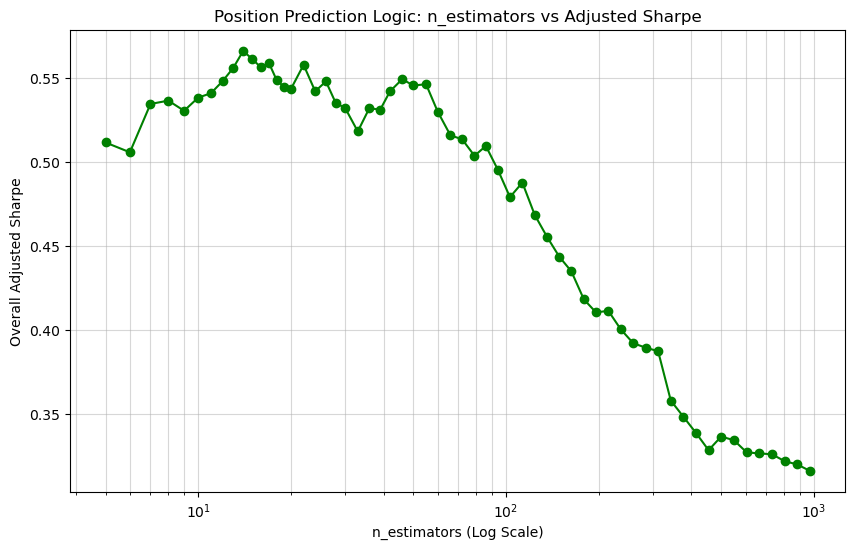

In [ ]:
import polars as pl
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from joblib import Parallel, delayed

# --- Configuration ---
# Set to -1 to use all CPU cores for folds. 
# WARNING: If using device='cuda', set this to 1 to avoid GPU OOM errors.
PARALLEL_JOBS = -1 
DEVICE = 'cuda' # or 'cpu'

def add_weekday_column(input_csv_path: str) -> pl.DataFrame:
    """
    Reads a CSV file, adds a 'weekday' column based on the 'Date' column,
    and saves the result to a new CSV file.

    Args:
        input_csv_path (str): The path to the source CSV file.
        output_csv_path (str): The path where the output CSV will be saved.
    """
    # Read the CSV file into a Polars DataFrame
    df = pl.read_csv(input_csv_path)

    # Add a new column named 'weekday'
    # 1. Select the 'Date' column.
    # 2. Convert the string representation to a proper date type.
    # 3. Use the .dt.weekday() function to get the day of the week (Monday=1, Sunday=7).
    # 4. Alias the new expression to 'weekday'.
    df_with_weekday = df.with_columns(
        pl.col("Date").str.to_date().dt.weekday().alias("weekday")
    )

    # Print the transformed DataFrame to the console to show the result
    returned_df = df_with_weekday.select(["date_id", "weekday"])
    return returned_df

# --- Helper Functions ---
def calculate_competition_score(y_true_df: pl.DataFrame, y_pred_signals: np.ndarray) -> float:
    solution = y_true_df.to_pandas()
    solution['position'] = y_pred_signals
    
    # Strategy returns
    solution['strategy_returns'] = (
        solution['risk_free_rate'] * (1 - solution['position']) +
        solution['position'] * solution['forward_returns']
    )
    
    # Metrics
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
    strategy_geo_mean = (1 + strategy_excess_returns).prod() ** (1 / len(solution)) - 1
    strategy_std = solution['strategy_returns'].std()
    
    if strategy_std == 0: return 0.0
    
    trading_days_per_yr = 252
    sharpe = strategy_geo_mean / strategy_std * np.sqrt(trading_days_per_yr)
    
    market_std = solution['forward_returns'].std()
    market_volatility = market_std * np.sqrt(trading_days_per_yr) * 100
    strategy_volatility = strategy_std * np.sqrt(trading_days_per_yr) * 100
    
    # Penalties
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol
    
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
    market_geo_mean = (1 + market_excess_returns).prod() ** (1 / len(solution)) - 1
    return_gap = max(0, (market_geo_mean - strategy_geo_mean) * 100 * trading_days_per_yr)
    return_penalty = 1 + (return_gap**2) / 100
    
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return adjusted_sharpe

def process_fold(train_idx, test_idx, X_all_np, y_all_np, n_estimators):
    """
    Worker function to process a single CV fold.
    """
    # 1. Slicing (Data is already numpy, so fast slicing)
    X_train = X_all_np[train_idx]
    X_test = X_all_np[test_idx]
    y_train_raw = y_all_np[train_idx] # This is 2D (n_samples, 1) usually
    
    # Flatten y_train for vectorization
    y_train_flat = y_train_raw.ravel()

    # 2. Vectorized Target Transformation (The "Position Logic")
    # Logic:
    #   if y > 0:  max(3.0 - 100*y, 0.3)
    #   if y == 0: 0.5
    #   if y < 0:  0.2
    
    # Default to 0.2 (covers the < 0 case)
    y_train_pos = np.full_like(y_train_flat, 0.2)
    
    # Case: y == 0
    y_train_pos[y_train_flat == 0] = 0.5
    
    # Case: y > 0
    pos_mask = y_train_flat > 0
    # Calculate formula for positive values
    # We use np.maximum to apply the 'max(..., 0.3)' logic element-wise
    y_train_pos[pos_mask] = np.maximum(3.0 - 100 * y_train_flat[pos_mask], 0.3)

    # 3. Fit Model (No Scaler)
    model = xgb.XGBRegressor(
        objective='reg:absoluteerror', 
        n_estimators=n_estimators, 
        device=DEVICE,
        learning_rate=0.05, 
        max_depth=5, 
        subsample=0.8, 
        colsample_bytree=0.8,
        n_jobs=1, # Single thread per model if running parallel folds
        random_state=42
    )
    
    model.fit(X_train, y_train_pos, verbose=False)
    predictions = model.predict(X_test)
    
    # 4. Signal Conversion (Clip only, as per Block 2 logic)
    signals = np.clip(predictions, 0.0, 2.0)
    
    return test_idx, signals

def run_position_search():
    # --- Data Loading (Same as before) ---
    print("Loading data...")
    full_train_df = pl.read_csv(TRAIN_DATA_PATH)
    df_raw = full_train_df.slice(3000)
    
    df = df_raw.with_columns(
        pl.selectors.numeric().fill_null(
            pl.selectors.numeric().rolling_mean(window_size=5, min_samples=1)
        )
    ).with_columns(pl.col("date_id").cast(pl.Int64))
    
    weekday_df = add_weekday_column(SPY_DATA_PATH)
    df = df.join(weekday_df, on="date_id", how="left")
    
    base_df = df.rename({'market_forward_excess_returns': 'target'})
    feature_cols = [col for col in base_df.columns if col != 'date_id']
    base_df = base_df.with_columns(pl.col(feature_cols).cast(pl.Float64, strict=False))
    base_df = base_df.drop('E7').with_columns(pl.all().forward_fill())
    
    new_features_df = generate_features_7(base_df)
    processed_df = pl.concat([base_df, new_features_df], how="horizontal")
    
    # --- Prepare Numpy Arrays Once ---
    base_features = [col for col in base_df.columns if col not in ["date_id", "forward_returns", "risk_free_rate", "target"]]
    ALL_FEATURES = base_features + new_features_df.columns
    TARGET_COL = "target"
    
    print("Converting to Numpy for speed...")
    X_all_np = processed_df.select(ALL_FEATURES).to_numpy()
    y_all_np = processed_df.select(TARGET_COL).to_numpy()
    scorer_info_all = processed_df.select(["forward_returns", "risk_free_rate"])
    
    # --- Hyperparameter Search ---
    n_estimators_list = []
    sharpe_scores = []
    
    current_n = 1
    tscv = TimeSeriesSplit(n_splits=10)
    
    print(f"Starting search (Parallel Jobs: {PARALLEL_JOBS})...")
    
    while current_n <= 500:
        print(f"n_estimators={current_n}...", end=" ")
        
        # Run CV folds in parallel
        # We pass indices to workers to save memory serialization overhead
        results = Parallel(n_jobs=PARALLEL_JOBS)(
            delayed(process_fold)(train_idx, test_idx, X_all_np, y_all_np, current_n)
            for train_idx, test_idx in tscv.split(X_all_np)
        )
        
        # Reassemble results in order
        entire_signal = []
        entire_ytest = scorer_info_all.clear()
        
        # Results are a list of (test_idx, signals) tuples
        # We need to reconstruct the full time series
        # Note: tscv splits are sequential, so extending works if results are ordered (Parallel keeps order)
        for test_idx, signals in results:
            entire_signal.extend(signals)
            entire_ytest.extend(scorer_info_all[test_idx])
            
        overall_score = calculate_competition_score(entire_ytest, entire_signal)
        print(f"Score: {overall_score:.4f}")
        
        n_estimators_list.append(current_n)
        sharpe_scores.append(overall_score)
        
        # Increment by 10%
        next_n = int(current_n * 1.10)
        current_n = next_n if next_n > current_n else current_n + 1

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_list, sharpe_scores, marker='o', linestyle='-', color='g')
    plt.title('Position Prediction Logic: n_estimators vs Adjusted Sharpe')
    plt.xlabel('n_estimators (Log Scale)')
    plt.ylabel('Overall Adjusted Sharpe')
    plt.xscale('log') # Log scale as requested
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()


run_position_search()

In [20]:
import lightgbm as lgb

def solve(df: pl.DataFrame) -> float:
    """
    Runs a full time-series cross-validation process to evaluate
    the features generated by the `generate_features` function.
    This version uses a LightGBM model.
    """
    # --- Helper functions (unchanged) ---
    def calculate_competition_score(y_true_df: pl.DataFrame, y_pred_signals: np.ndarray) -> float:
        ''' Calculates the competition score based on true values and predicted signals. '''
        solution = y_true_df.to_pandas()
        solution['position'] = y_pred_signals
        solution['strategy_returns'] = (
            solution['risk_free_rate'] * (1 - solution['position']) +
            solution['position'] * solution['forward_returns']
        )
        strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
        strategy_geo_mean = (1 + strategy_excess_returns).prod() ** (1 / len(solution)) - 1
        strategy_std = solution['strategy_returns'].std()
        if strategy_std == 0: return 0.0
        trading_days_per_yr = 252
        sharpe = strategy_geo_mean / strategy_std * np.sqrt(trading_days_per_yr)
        market_std = solution['forward_returns'].std()
        market_volatility = market_std * np.sqrt(trading_days_per_yr) * 100
        strategy_volatility = strategy_std * np.sqrt(trading_days_per_yr) * 100
        excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
        vol_penalty = 1 + excess_vol
        market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
        market_geo_mean = (1 + market_excess_returns).prod() ** (1 / len(solution)) - 1
        return_gap = max(0, (market_geo_mean - strategy_geo_mean) * 100 * trading_days_per_yr)
        return_penalty = 1 + (return_gap**2) / 100
        adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
        print(f"Strategy Volatility: {strategy_volatility:.2f}%, Market Volatility: {market_volatility:.2f}%, Sharpe: {sharpe:.4f}, Adjusted Sharpe: {adjusted_sharpe:.4f}")
        return adjusted_sharpe

    def convert_to_signal(predictions: np.ndarray, multiplier: float = 400.0) -> np.ndarray:
        ''' Converts raw model predictions into trading signals in the range [0, 2]. '''
        signals = predictions * multiplier + 1
        return np.clip(signals, 0.0, 2.0)

    # --- Feature Generation and Data Prep ---
    base_df = df.rename({'market_forward_excess_returns': 'target'})
    feature_cols = [col for col in base_df.columns if col != 'date_id']
    base_df = base_df.with_columns(pl.col(feature_cols).cast(pl.Float64, strict=False))
    base_df = base_df.with_columns(pl.all().forward_fill()).drop_nulls()

    # Generate and combine features
    # new_features_df_1 = generate_features_1(base_df)
    # new_features_df_2 = generate_features_2(base_df)
    # new_features_df_3 = generate_features_3(base_df)
    # new_features_df_4 = generate_features_4(base_df)
    # new_features_df_5 = generate_features_5(base_df)
    # new_features_df_6 = generate_features_6(base_df)
    # #newf = [new_features_df_1, new_features_df_2, new_features_df_3, new_features_df_4, new_features_df_5, new_features_df_6]
    # newf = [new_features_df_1, new_features_df_2, new_features_df_3, new_features_df_5, new_features_df_6]
    # new_features_df = pl.concat(newf, how="horizontal")
    new_features_df = generate_features_7(base_df)
    
    processed_df = pl.concat([base_df, new_features_df], how="horizontal")

    # Setup data for modeling
    base_features = [col for col in base_df.columns if col not in ["date_id", "forward_returns", "risk_free_rate", "target"]]
    new_feature_names = new_features_df.columns
    ALL_FEATURES = base_features + new_feature_names
    TARGET_COL = "target"

    X = processed_df.select(ALL_FEATURES)
    y = processed_df.select(TARGET_COL)
    scorer_info_df = processed_df.select(["forward_returns", "risk_free_rate"])

    # --- Time-Series Cross-Validation ---
    nsplits = 20
    tscv = TimeSeriesSplit(n_splits=nsplits)
    cv_scores = []

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        y_test_info = scorer_info_df[test_index]

        # Define the LightGBM model
        model = lgb.LGBMRegressor(
            objective='regression_l1',  # MAE, an alternative to squared error
            n_estimators=50,
            device='cpu',              # Use 'cpu' if you don't have a compatible GPU
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,             # Equivalent to 'bagging_fraction'
            colsample_bytree=0.8,      # Equivalent to 'feature_fraction'
            n_jobs=-1,
            random_state=42,
            verbose=-1                 # Suppress verbose output
        )
        
        # Train the model
        # Convert to NumPy arrays before fitting and predicting
        model.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

        predictions = model.predict(X_test.to_numpy())
        signals = convert_to_signal(predictions)
        score = calculate_competition_score(y_test_info, signals)
        cv_scores.append(score)

    mean_score = np.mean(cv_scores)
    print(f"\nMean CV Score: {mean_score:.4f}, std: {np.std(cv_scores):.4f}")
    return mean_score

if __name__ == "__main__":
    # Example call to evaluate function
    final_score = evaluate(0)
    print(f"Final Evaluation Score: {final_score:.4f}")

(4990, 98)

--- Joining weekday feature onto sliced data ---
Strategy Volatility: 29.02%, Market Volatility: 18.04%, Sharpe: -0.1376, Adjusted Sharpe: -0.0977
Strategy Volatility: 19.91%, Market Volatility: 12.06%, Sharpe: -0.6682, Adjusted Sharpe: -0.3534
Strategy Volatility: 28.14%, Market Volatility: 18.73%, Sharpe: 0.2388, Adjusted Sharpe: 0.1727
Strategy Volatility: 15.72%, Market Volatility: 11.29%, Sharpe: 0.3979, Adjusted Sharpe: 0.3187
Strategy Volatility: 16.21%, Market Volatility: 13.57%, Sharpe: 2.0374, Adjusted Sharpe: 2.0374


/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/polars/series/series.py:1571: RuntimeWarning: invalid value encountered in log
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegress

Strategy Volatility: 61.86%, Market Volatility: 33.47%, Sharpe: -0.3417, Adjusted Sharpe: -0.1078
Strategy Volatility: 20.21%, Market Volatility: 19.49%, Sharpe: 2.2324, Adjusted Sharpe: 2.2324
Strategy Volatility: 18.39%, Market Volatility: 15.95%, Sharpe: 2.5822, Adjusted Sharpe: 2.3098
Strategy Volatility: 19.95%, Market Volatility: 12.90%, Sharpe: 1.7831, Adjusted Sharpe: 1.3246
Strategy Volatility: 17.41%, Market Volatility: 10.75%, Sharpe: 2.3257, Adjusted Sharpe: 1.6387
Strategy Volatility: 30.53%, Market Volatility: 19.82%, Sharpe: -0.7726, Adjusted Sharpe: -0.1490


/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRe

Strategy Volatility: 47.65%, Market Volatility: 25.52%, Sharpe: -0.4651, Adjusted Sharpe: -0.2476
Strategy Volatility: 32.72%, Market Volatility: 23.90%, Sharpe: -1.1266, Adjusted Sharpe: -0.4426
Strategy Volatility: 18.46%, Market Volatility: 14.92%, Sharpe: 1.1653, Adjusted Sharpe: 1.1234
Strategy Volatility: 8.91%, Market Volatility: 11.06%, Sharpe: 2.6834, Adjusted Sharpe: 2.6834


/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRe

Strategy Volatility: 12.34%, Market Volatility: 11.87%, Sharpe: 2.2307, Adjusted Sharpe: 0.8824
Strategy Volatility: 12.58%, Market Volatility: 10.33%, Sharpe: 1.6605, Adjusted Sharpe: 1.6304
Strategy Volatility: 18.00%, Market Volatility: 14.38%, Sharpe: 1.2630, Adjusted Sharpe: 1.2008
Strategy Volatility: 37.35%, Market Volatility: 21.45%, Sharpe: -1.2254, Adjusted Sharpe: -0.3728
Strategy Volatility: 17.23%, Market Volatility: 11.31%, Sharpe: 3.4064, Adjusted Sharpe: 2.5749

Mean CV Score: 0.9179, std: 1.0660
Final Evaluation Score: 0.9179


/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [15]:
import polars as pl
import numpy as np
import xgboost as xgb  # You can keep or remove this
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler  # <-- ADD THIS

# --- ADD THESE FOR LSTM ---
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
# ---------------------------

# The training data path should be updated to your actual training file.
TRAIN_DATA_PATH = "./kaggle/train.csv"
SPY_DATA_PATH = "./kaggle/spy-historical.csv"

# Optional: Set a random seed for reproducibility in Keras
tf.keras.utils.set_random_seed(42)

def create_sequences(X_data, y_data, lookback):
    """
    Converts 2D feature data and 1D/2D target data into 3D sequences
    for LSTM.
    
    X_data: NumPy array of features (samples, n_features)
    y_data: NumPy array (y_train) or Polars DataFrame (y_test_info)
    lookback: Number of timesteps to look back
    """
    X_seq, y_seq = [], []
    
    for i in range(lookback, len(X_data)):
        # Get the sequence of features [t-lookback, ..., t-1]
        X_seq.append(X_data[i-lookback:i, :])
        
        # Get the target at time [t]
        y_seq.append(y_data[i])

    # Convert lists to a NumPy array for features
    X_seq_arr = np.array(X_seq)
    
    # Handle y_data (which could be a NumPy array or Polars DataFrame)
    if isinstance(y_data, pl.DataFrame):
        # This is the y_test_info DataFrame. Re-concat it.
        y_seq_arr = pl.concat(y_seq)
    else:
        # This is the y_train NumPy array.
        y_seq_arr = np.array(y_seq)
        
    return X_seq_arr, y_seq_arr

def build_lstm_model(lookback, n_features):
    """
    Builds a simple Keras LSTM model.
    """
    inputs = Input(shape=(lookback, n_features))
    
    # A simple LSTM layer
    x = LSTM(units=50, return_sequences=False)(inputs)
    x = Dropout(0.2)(x)
    
    # Output layer: 1 neuron for regression
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    # Using 'mae' (Mean Absolute Error) as the loss,
    # since it's the same as the competition metric.
    model.compile(optimizer='adam', loss='mean_absolute_error')
    
    return model

def evaluate(individual_index: int) -> float:
    """
    Trains and evaluates a model using time-series cross-validation.
    This version is modified for an LSTM.
    """
    
    # --- Define new hyperparameters for LSTM ---
    LOOKBACK = 10       # How many days to look back
    EPOCHS = 20         # How many times to train on the data
    BATCH_SIZE = 64     # How many samples per training update
    # -------------------------------------------

    # Load data (this logic remains the same)
        # --- Helper functions (unchanged) ---
    def calculate_competition_score(y_true_df: pl.DataFrame, y_pred_signals: np.ndarray) -> float:
        ''' Calculates the competition score based on true values and predicted signals. '''
        solution = y_true_df.to_pandas()
        solution['position'] = y_pred_signals
        solution['strategy_returns'] = (
            solution['risk_free_rate'] * (1 - solution['position']) +
            solution['position'] * solution['forward_returns']
        )
        strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
        strategy_geo_mean = (1 + strategy_excess_returns).prod() ** (1 / len(solution)) - 1
        strategy_std = solution['strategy_returns'].std()
        if strategy_std == 0: return 0.0
        trading_days_per_yr = 252
        sharpe = strategy_geo_mean / strategy_std * np.sqrt(trading_days_per_yr)
        market_std = solution['forward_returns'].std()
        market_volatility = market_std * np.sqrt(trading_days_per_yr) * 100
        strategy_volatility = strategy_std * np.sqrt(trading_days_per_yr) * 100
        excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
        vol_penalty = 1 + excess_vol
        market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
        market_geo_mean = (1 + market_excess_returns).prod() ** (1 / len(solution)) - 1
        return_gap = max(0, (market_geo_mean - strategy_geo_mean) * 100 * trading_days_per_yr)
        return_penalty = 1 + (return_gap**2) / 100
        adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
        print(f"Strategy Volatility: {strategy_volatility:.2f}%, Market Volatility: {market_volatility:.2f}%, Sharpe: {sharpe:.4f}, Adjusted Sharpe: {adjusted_sharpe:.4f}")
        return adjusted_sharpe

    def convert_to_signal(predictions: np.ndarray, multiplier: float = 400.0) -> np.ndarray:
        ''' Converts raw model predictions into trading signals in the range [0, 2]. '''
        signals = predictions * multiplier + 1
        return np.clip(signals, 0.0, 2.0)

    # --- Feature Generation and Data Prep ---
    full_train_df = pl.read_csv(TRAIN_DATA_PATH)
    # Use a slice of data for faster evaluation runs during development
    df_raw = full_train_df.slice(4000)
    print(df_raw.shape)

    #fill nulls in df with mean
    df = df_raw.with_columns(
        # Select all numeric columns for the operation
        pl.selectors.numeric()
          # Step 1: Attempt to fill with the rolling mean of each respective column
          .fill_null(
              pl.selectors.numeric().rolling_mean(window_size=5, min_samples=1)
          )
          # Step 2: Fall back to the global column mean for any remaining nulls
          #.fill_null(strategy='mean')
    )
    df = df.with_columns(
    pl.col("date_id").cast(pl.Int64)
    )

    base_df = df.rename({'market_forward_excess_returns': 'target'})
    feature_cols = [col for col in base_df.columns if col != 'date_id']
    base_df = base_df.with_columns(pl.col(feature_cols).cast(pl.Float64, strict=False))
    base_df = base_df.with_columns(pl.all().forward_fill())#.drop_nulls()

    # Generate and combine features
    # new_features_df_1 = generate_features_1(base_df)
    # new_features_df_2 = generate_features_2(base_df)
    # new_features_df_3 = generate_features_3(base_df)
    # new_features_df_4 = generate_features_4(base_df)
    # new_features_df_5 = generate_features_5(base_df)
    # new_features_df_6 = generate_features_6(base_df)
    # #newf = [new_features_df_1, new_features_df_2, new_features_df_3, new_features_df_4, new_features_df_5, new_features_df_6]
    # newf = [new_features_df_1, new_features_df_2, new_features_df_3, new_features_df_5, new_features_df_6]
    # new_features_df = pl.concat(newf, how="horizontal")
    new_features_df = generate_features_7(base_df)
    
    processed_df = pl.concat([base_df, new_features_df], how="horizontal").with_columns(
        # Select all numeric columns for the operation
        pl.selectors.numeric()
          # Step 1: Attempt to fill with the rolling mean of each respective column
          .fill_null(
              pl.selectors.numeric().rolling_mean(window_size=5, min_samples=1)
          )
          # Step 2: Fall back to the global column mean for any remaining nulls
          .fill_null(strategy='mean')
    )

    # Setup data for modeling
    base_features = [col for col in base_df.columns if col not in ["date_id", "forward_returns", "risk_free_rate", "target"]]
    new_feature_names = new_features_df.columns
    ALL_FEATURES = base_features + new_feature_names
    TARGET_COL = "target"

    X = processed_df.select(ALL_FEATURES)
    y = processed_df.select(TARGET_COL)
    scorer_info_df = processed_df.select(["forward_returns", "risk_free_rate"])
    #X, y, scorer_info_df = load_and_preprocess_data(individual_index)
    if X is None:
        return 0.0

    # Time-Series Cross-Validation
    nsplits = 10  # Reduced splits, as NN training is slow
    tscv = TimeSeriesSplit(n_splits=nsplits)
    cv_scores = []
    
    print(f"Starting LSTM cross-validation with LOOKBACK={LOOKBACK}...")

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        print(f"  Starting Fold {i+1}/{nsplits}...")
        
        # 1. Get raw data for this split
        X_train_raw = X[train_index]
        X_test_raw = X[test_index]
        y_train_raw = y[train_index].to_numpy() # Convert y_train to NumPy
        y_test_info_raw = scorer_info_df[test_index]

        # 2. --- NORMALIZATION ---
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_raw.to_numpy())
        X_test_scaled = scaler.transform(X_test_raw.to_numpy())

        # --- ADD THIS FIX ---
        # Replace any NaNs/Infs (from divide-by-zero) with 0
        X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
        X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)
        # --------------------

        # 3. --- DATA RESHAPING (SEQUENCING) ---
        X_train_seq, y_train_seq = create_sequences(
            X_train_scaled, y_train_raw, LOOKBACK
        )
        
        # Create 3D sequences for testing
        # CRITICAL: We also sequence y_test_info_raw to keep the scores aligned
        X_test_seq, y_test_info_seq = create_sequences(
            X_test_scaled, y_test_info_raw, LOOKBACK
        )
        
        # Stop if we don't have enough data to test (e.g., test set < LOOKBACK)
        if len(X_test_seq) == 0:
            print(f"  Skipping Fold {i+1}: Not enough test data to create sequences.")
            continue

        # 4. --- BUILD AND TRAIN MODEL ---
        n_features = X_train_seq.shape[2]
        model = build_lstm_model(LOOKBACK, n_features)
        
        # Use EarlyStopping to prevent overfitting
        early_stopping = EarlyStopping(
            monitor='val_loss', patience=3, restore_best_weights=True
        )

        model.fit(
            X_train_seq, y_train_seq,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.1,  # Use 10% of train data for validation
            callbacks=[early_stopping],
            verbose=0  # Set to 1 to see training progress
        )

        # 5. --- PREDICT AND SCORE ---
        # Predict on the 3D test sequences
        predictions_scaled = model.predict(X_test_seq, verbose=0)
        
        # predictions will be (n_samples, 1), flatten to (n_samples,)
        predictions = predictions_scaled.flatten()

        signals = convert_to_signal(predictions)
        
        # Score against the SEQUENCED y_test_info DataFrame
        score = calculate_competition_score(y_test_info_seq, signals)
        cv_scores.append(score)
        print(f"  Fold {i+1}/{nsplits} Score: {score:.4f}")

    if not cv_scores:
        print("No scores were recorded. Check data and LOOKBACK period.")
        return 0.0

    mean_score = np.mean(cv_scores)
    print(f"\nMean CV Score: {mean_score:.4f}, std: {np.std(cv_scores):.4f}")
    return mean_score

evaluate(0)

(4990, 98)
Starting LSTM cross-validation with LOOKBACK=10...
  Starting Fold 1/10...


/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/polars/series/series.py:1571: RuntimeWarning: invalid value encountered in log
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Strategy Volatility: 21.82%, Market Volatility: 28.77%, Sharpe: 0.2020, Adjusted Sharpe: 0.2020
  Fold 1/10 Score: 0.2020
  Starting Fold 2/10...


/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Strategy Volatility: 15.06%, Market Volatility: 16.55%, Sharpe: 1.6012, Adjusted Sharpe: 1.6012
  Fold 2/10 Score: 1.6012
  Starting Fold 3/10...


/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Strategy Volatility: 30.77%, Market Volatility: 18.48%, Sharpe: 0.8547, Adjusted Sharpe: 0.5833
  Fold 3/10 Score: 0.5833
  Starting Fold 4/10...
Strategy Volatility: 20.22%, Market Volatility: 11.09%, Sharpe: 1.7110, Adjusted Sharpe: 1.0541
  Fold 4/10 Score: 1.0541
  Starting Fold 5/10...
Strategy Volatility: 16.73%, Market Volatility: 14.90%, Sharpe: -0.6085, Adjusted Sharpe: -0.1837
  Fold 5/10 Score: -0.1837
  Starting Fold 6/10...
Strategy Volatility: 1.08%, Market Volatility: 10.61%, Sharpe: 0.5491, Adjusted Sharpe: 0.2097
  Fold 6/10 Score: 0.2097
  Starting Fold 7/10...
Strategy Volatility: 28.08%, Market Volatility: 19.60%, Sharpe: 0.4607, Adjusted Sharpe: 0.3739
  Fold 7/10 Score: 0.3739
  Starting Fold 8/10...
Strategy Volatility: 29.39%, Market Volatility: 15.51%, Sharpe: 1.9621, Adjusted Sharpe: 1.1574
  Fold 8/10 Score: 1.1574
  Starting Fold 9/10...
Strategy Volatility: 38.23%, Market Volatility: 19.72%, Sharpe: -0.2548, Adjusted Sharpe: -0.0878
  Fold 9/10 Score: -0.08

0.5239453937354256